# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [4]:

# load filenames for human and dog images

dog_files_test = np.array(glob("dogImages/test/*/*"))
dog_files_train = np.array(glob("dogImages/train/*/*"))
dog_files_valid = np.array(glob("dogImages/valid/*/*"))

# print number of images in each dataset
print('There are %d total dog images in test.' % len(dog_files_test))
print('There are %d total dog images in train.' % len(dog_files_train))
print('There are %d total dog images in valid.' % len(dog_files_valid))

There are 836 total dog images in test.
There are 6680 total dog images in train.
There are 835 total dog images in valid.


In [5]:
!pip install opencv-python
#!pip install nvidia-ml-py3

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


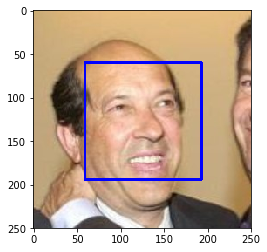

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [8]:
#from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
# Do NOT modify the code above this line.
tp = np.mean([face_detector(h) for h in human_files_short])
# Do NOT modify the code above this line.
fp = np.mean([face_detector(h) for h in dog_files_short])

print(f" {tp }% of humans face are detected ")
print(f" {fp }% of dogs face are confused with human")


 0.99% of humans face are detected 
 0.18% of dogs face are confused with human


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [9]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

In [10]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
img_short_side_resize = 224
img_input_size = 224
shuffle = True
num_workers = 16
batch_size = 64

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [11]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)
RESNET50 = models.resnet50(pretrained=True)
INCEPTIVEV3 = models.inception_v3(pretrained=True)
ALEXNET = models.alexnet(pretrained=True)
# check if CUDA is available
model_list = [ALEXNET.eval(),VGG16.eval(),RESNET50.eval(),INCEPTIVEV3.eval()]
model_names = ["alexnet","VGG16","resnet50","inception_v3"]
#use_cuda = torch.cuda.is_available()

use_cuda = torch.cuda.is_available()
if not use_cuda:
    device = "cpu"
    print('Training on CPU')   
else:
    device = torch.device("cuda:0")
    print('Training on GPU ...')   
    print("Using",torch.cuda.get_device_name(device))
# move model to GPU if CUDA is available
#if use_cuda:
   # VGG16 = VGG16.cuda()
VGG16 = VGG16.to(device)

Training on GPU ...
Using Tesla V100-SXM2-16GB


In [12]:
def im_convert(tensor):
    """ Display a tensor as an image. """    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

def show_image_from_path(img_path, title = None):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    if title is not None:
        plt.gca().set_title(title)
    plt.show()

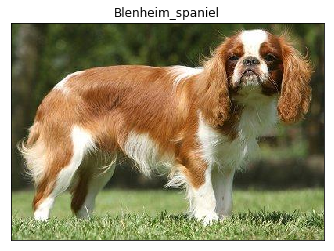

In [13]:

from PIL import Image
import torchvision.transforms as transforms
import json
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

def pre_trained_predict(img_path, model, device):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    ''' 
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path).convert('RGB')
    # To avoid changing the aspect ratio of the image we can use the FiveCrop transform, which returns the center and the 
    # corner crops. Five outputs are calculated and then averaged.
    in_transform = transforms.Compose([
                        transforms.Resize(img_short_side_resize),  
                        transforms.FiveCrop(img_input_size),
                        transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                    transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])        
    
    output = torch.argmax(model(in_transform(image).to(device)).mean(0))
   
    return output.to("cpu").item() # predicted class index


test_image = dog_files_short[0]
pred = pre_trained_predict(test_image, VGG16, device)
show_image_from_path(test_image, title = idx2label[pred])

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, model, device):
    ## TODO: Complete the function.
    out = pre_trained_predict(img_path,model,device)
    return out >= 151 and out <= 268 # true/false


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
0 and 97% accordingly.

In [15]:
dogs_detected_correctly = [dog_detector(img_path,VGG16,device) for img_path in dog_files_short]
dogs_detected_incorrectly = [dog_detector(img_path,VGG16,device) for img_path in human_files_short]

In [16]:
tpr_vgg16 = np.mean(dogs_detected_correctly)
fpr_vgg16 = np.mean(dogs_detected_incorrectly)

print(f"VGG16: {fpr_vgg16 * 100:.3f}% of humans confused with dogs")
print(f"VGG16: {tpr_vgg16 * 100:.3f}% dogs correctly identified")

VGG16: 0.000% of humans confused with dogs
VGG16: 97.000% dogs correctly identified


In [17]:
VGG16 = VGG16.to("cpu")
torch.cuda.empty_cache()
tpr = np.zeros(len(model_list))
fpr = np.zeros(len(model_list))
for i in range(len(model_list)):
    model = model_list[i].to(device)
    tpr[i] = np.mean([dog_detector(img_path, model, device) for img_path in dog_files[:500]])
    fpr[i] = np.mean([dog_detector(img_path, model, device) for img_path in human_files[:500]])
    model = model.to("cpu")

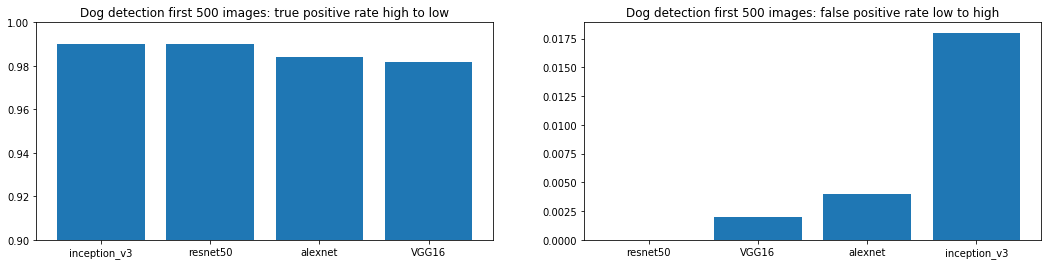

In [18]:
idx_tpr = np.argsort(tpr)[::-1]
idx_fpr = np.argsort(fpr)

fig,ax = plt.subplots(1,2,figsize = (18,4))
ax[0].bar([model_names[i] for i in idx_tpr],tpr[idx_tpr])
ax[0].set_title(f"Dog detection first 500 images: true positive rate high to low")
ax[0].set_ylim((0.9,1))
ax[1].bar([model_names[i] for i in idx_fpr],fpr[idx_fpr])
ax[1].set_title("Dog detection first 500 images: false positive rate low to high")
plt.show()

__Answer:__ 
Resnet50 outperforms other considering low fp and high tp.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [19]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
transform_resize = 224
transform_crop = 224
data_directory = "dogImages"

print("load image data ... ")
# define transforms for the training data and testing data
# train_transforms = transforms.Compose([transforms.Resize(transform_resize),
#                                        transforms.CenterCrop(transform_crop),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.RandomVerticalFlip(),
#                                        transforms.RandomRotation(20),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize([0.485, 0.456, 0.406],
#                                                             [0.229, 0.224, 0.225])])
train_transforms = transforms.Compose([transforms.Resize(transform_resize),
                                       transforms.RandomHorizontalFlip(),
                                       #transforms.CenterCrop(transform_crop),
                                       transforms.RandomResizedCrop(transform_resize, scale=(0.08,1), ratio=(1,1)),
                                       #transforms.RandomHorizontalFlip(),
                                       #transforms.RandomVerticalFlip(),
                                       #simtransforms.RandomRotation(20),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(transform_resize),
                                      transforms.CenterCrop(transform_crop),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder( data_directory + '/train', transform=train_transforms )
test_data = datasets.ImageFolder( data_directory + '/test', transform=test_transforms )
valid_data = datasets.ImageFolder( data_directory + '/valid', transform=test_transforms )

# ---- print out some data stats ----
print('  Number of train images: ', len(train_data))
print('  Number of test images:  ', len(test_data))
print('  Number of valid images: ', len(valid_data))
# -----------------------------------

trainloader = torch.utils.data.DataLoader( train_data, batch_size=32, shuffle=True )
testloader = torch.utils.data.DataLoader( test_data, batch_size=16 )
validloader = torch.utils.data.DataLoader( valid_data, batch_size=16 )

# create dictionary for all loaders in one
loaders_scratch = {}
loaders_scratch['train'] = trainloader
loaders_scratch['valid'] = validloader
loaders_scratch['test'] = testloader
n_classes = len(train_data.classes)


load image data ... 
  Number of train images:  6680
  Number of test images:   836
  Number of valid images:  835


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: when you use a pre-trained model you have to resize and normalise the input to the same format the network was originally trained on.with that:
I croped immage to 224*224 (firts thing) and used this normilization  transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225] acording to pytorch.
I also did the augmentation on image(randon rotation and flips) to avoid overfitting.
I did it as a commin practice and I didnt check if it acturaly helps or not.


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [21]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, n_classes, depth_1 = 32):
        super(Net, self).__init__()        
        # Keep track of things
        depth_2 = depth_1 * 2
        depth_3 = depth_2 * 2      
        # Max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Conv set 1
        self.conv1_1 = nn.Conv2d(3,depth_1,3,stride = 1,padding = 1)
        self.conv1_2 = nn.Conv2d(depth_1,depth_1,3,stride = 1,padding = 1)
        self.bn1_1 = nn.BatchNorm2d(depth_1)
        self.bn1_2 = nn.BatchNorm2d(depth_1)
        # Conv set 2
        self.conv2_1 = nn.Conv2d(depth_1,depth_2,3,stride = 1,padding = 1)
        self.conv2_2 = nn.Conv2d(depth_2,depth_2,3,stride = 1,padding = 1)
        self.bn2_1 = nn.BatchNorm2d(depth_2)
        self.bn2_2 = nn.BatchNorm2d(depth_2)        
        # Conv set 3
        self.conv3_1 = nn.Conv2d(depth_2,depth_3,3,stride = 1,padding = 1)
        self.conv3_2 = nn.Conv2d(depth_3,depth_3,3,stride = 1,padding = 1)
        self.bn3_1 = nn.BatchNorm2d(depth_3)
        self.bn3_2 = nn.BatchNorm2d(depth_3)
        # Output correspond to number of dogs breds
        self.fc_out = nn.Linear(depth_3,n_classes)   
        # Initialize weights
        nn.init.kaiming_normal_(self.conv1_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv1_2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2_2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3_2.weight, nonlinearity='relu') 
            
    def forward(self, x):
        # Conv 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool(x)
        # Conv 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool(x)
        # Conv 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool(x)
        # First we fuse the height and width dimensions (2 and 3) 
        x = x.view(x.size(0),x.size(1),-1)        
        # And now max global pooling 
        x = x.max(2)[0]
        # Output
        x = self.fc_out(x)
        return x


#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net(n_classes)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
Convolotional layer depth start at 32 in firts layer and doubled after each max pool to preserve computational co
Stride and padding are 1 and relu as activation function to avoid vanishing gadient.
The architecture is inspired by the VGG networks, having three sets of two convolutional layers, each of them followed by max pooling. 

I have tweaked learning_rate and epoches manualy and this is the best I get, I am sure there are better optimal values for this hyperparameters .

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [27]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

### TODO: select loss function
#criterion_scratch = None

### TODO: select optimizer
#optimizer_scratch = None
param_learning_rate =  0.01 # I tewaked it manualy, see my project.pdf 
criterion_scratch = nn.CrossEntropyLoss() # Based on pytorch recomandation for multi class clasification with high precision and recall 

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=param_learning_rate)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [30]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += loss.item()*data.size(0)    
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item() * data.size(0)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            print('  Saving model ...')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        else:
            print("")
            
    # return trained model
    return model


# train the model
model_scratch = train(200, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'final_model/model_scratch_final.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('final_model/model_scratch_final.pt'))

Epoch: 1 	Training Loss: 26336.329796 	Validation Loss: 3368.684551
  Saving model ...
Epoch: 2 	Training Loss: 26036.877903 	Validation Loss: 3308.159988
  Saving model ...
Epoch: 3 	Training Loss: 25804.996140 	Validation Loss: 3314.273940

Epoch: 4 	Training Loss: 25463.876923 	Validation Loss: 3332.963811

Epoch: 5 	Training Loss: 25205.057810 	Validation Loss: 3234.836575
  Saving model ...
Epoch: 6 	Training Loss: 24870.728188 	Validation Loss: 3154.380901
  Saving model ...
Epoch: 7 	Training Loss: 24663.039005 	Validation Loss: 3297.936057

Epoch: 8 	Training Loss: 24378.823763 	Validation Loss: 3137.165853
  Saving model ...
Epoch: 9 	Training Loss: 24319.077967 	Validation Loss: 3101.465567
  Saving model ...
Epoch: 10 	Training Loss: 23871.273857 	Validation Loss: 3238.819590

Epoch: 11 	Training Loss: 23736.661278 	Validation Loss: 3233.148109

Epoch: 12 	Training Loss: 23649.828779 	Validation Loss: 3254.556899

Epoch: 13 	Training Loss: 23387.614754 	Validation Loss: 3059

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [31]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.229593


Test Accuracy: 41% (350/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [32]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch
loaders_transfer_wfc = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.



In [33]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

In [34]:

# Freezing all parameters
for param in model_transfer.parameters():
    param.requires_grad = False

In [35]:
model_transfer.fc = nn.Linear(model_transfer.fc.in_features,n_classes)
# Initialize the weights of the new layer
nn.init.kaiming_normal_(model_transfer.fc.weight, nonlinearity='relu')
# Transfer to GPU 
model_transfer = model_transfer.to(device)

__Answer:__ 
Resnet did a better job (comparing other pre trained models) in my evaluation at the ebgining of the notebook  and I choos it as my final model.Also it's easy to use it for transfer learning, as only the final linear layer needs to be replaced.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [44]:
#criterion_transfer = nn.CrossEntropyLoss()

# for VGG 19
#optimizer_transfer = optim.SGD(filter(lambda p: p.requires_grad,model_transfer.parameters()), lr=param_learning_rate)

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(),0.001) 
scheduler_transfer = ReduceLROnPlateau(optimizer_transfer, 'min', verbose = True, factor = 0.5, patience = 7)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [45]:
# train the model
#model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
#param_epochs = 10
#train(param_epochs, loaders_transfer, model_transfer, optimizer_transfer, 
                      # criterion_transfer, use_cuda, 'model_transfer.pt')
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))
model_transfer = train(50, loaders_transfer, model_transfer, optimizer_transfer, 
                       criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 6629.181796 	Validation Loss: 550.837967
  Saving model ...
Epoch: 2 	Training Loss: 5923.371487 	Validation Loss: 511.592845
  Saving model ...
Epoch: 3 	Training Loss: 5740.089914 	Validation Loss: 457.845996
  Saving model ...
Epoch: 4 	Training Loss: 5470.151806 	Validation Loss: 448.174387
  Saving model ...
Epoch: 5 	Training Loss: 5151.091392 	Validation Loss: 503.240277

Epoch: 6 	Training Loss: 5043.229277 	Validation Loss: 477.093365

Epoch: 7 	Training Loss: 5249.469635 	Validation Loss: 472.370835

Epoch: 8 	Training Loss: 5017.525213 	Validation Loss: 439.471705
  Saving model ...
Epoch: 9 	Training Loss: 4659.332493 	Validation Loss: 380.162534
  Saving model ...
Epoch: 10 	Training Loss: 4915.547442 	Validation Loss: 443.145821

Epoch: 11 	Training Loss: 4751.646067 	Validation Loss: 467.480759

Epoch: 12 	Training Loss: 4747.436118 	Validation Loss: 462.447272

Epoch: 13 	Training Loss: 4707.023564 	Validation Loss: 509.003391

Epoch: 14 	Traini

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [46]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.617244


Test Accuracy: 85% (712/836)


In [47]:
def process_image_to_tensor(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an tensor array
    As per Pytorch documentations: All pre-trained models expect input images normalized in the same way, 
    i.e. mini-batches of 3-channel RGB images
    of shape (3 x H x W), where H and W are expected to be at least 224. 
    The images have to be loaded in to a range of [0, 1] and 
    then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
    You can use the following transform to normalize:
    '''
    # define transforms for the training data and testing data
    prediction_transforms = transforms.Compose([transforms.Resize(transform_resize),
                                          transforms.CenterCrop(transform_crop),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    
    img_pil = Image.open( image ).convert('RGB')
    img_tensor = prediction_transforms( img_pil )[:3,:,:].unsqueeze(0)
    
    return img_tensor

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

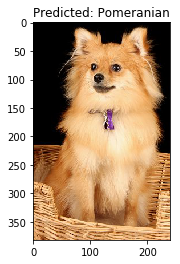

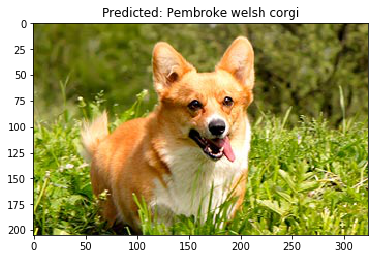

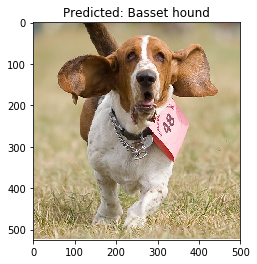

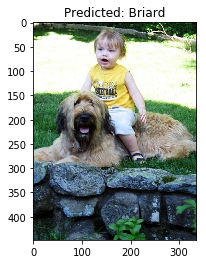

In [48]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]
def predict_breed_transfer(img_path):
    
    # load the image and return the predicted breed
    image_tensor = process_image_to_tensor(img_path)

    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = model_transfer(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]


def display_image(img_path, title="Title"):
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()
    h
import random
from PIL import Image, ImageFile 

for image in random.sample(list(dog_files_short), 4): 
    predicted_breed = predict_breed_transfer(image)
    display_image(image, title="Predicted: {}".format(predicted_breed) )

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [57]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
#RESNET50 = models.resnet50(pretrained=True)
model_transfer = model_transfer.to(device)
model_dog_detector = ALEXNET # Alexnet weirdly turned out to be the best dog detector, resnet was disapointing despite the earlier observation!
model_dog_detector = model_dog_detector.to(device)
#RESNET50=RESNET50.to(device)
#ALEXNET=ALEXNET.to(device)
def run_app(img_path):
    
    
    ## handle cases for a human face, dog, and neither
    if (face_detector(img_path)):
            print("Hello Human!")
            predicted_breed = predict_breed_transfer(img_path)
            display_image(img_path, title="Predicted: {}".format(predicted_breed) )

            print("You look like a ...")
            print(predicted_breed)

        # check if image has dogs:
    elif dog_detector(img_path,model_transfer,device):
            print("Hello Dog!")
            predicted_breed = predict_breed_transfer(img_path)
            display_image(img_path, title="Predicted: {}".format(predicted_breed) )

            print("Your breed is most likley ...")
            print(predicted_breed)
        # otherwise
    else:
            print("Oh, we're sorry! We couldn't detect any dog or human face in the image.")
            display_image(img_path, title="...")
            print("Try another!")

    print("\n")
    


In [55]:
custom_files = np.array(glob("Custom/*"))
print(len(custom_files))

7


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for impro
vement)
I have started with resnet that I thouth is the best model, but results was dispointing in detecting dogs, it turns out alexnet is the best.
For improving we could:
ensemble multiple learner
tweak the hyper parameters like learning rate
develpe two model one for dogs and one for human

Oh, we're sorry! We couldn't detect any dog or human face in the image.


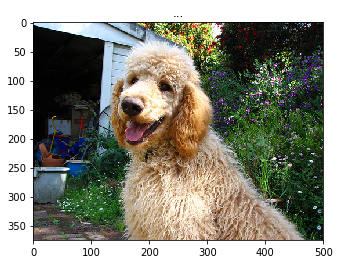

Try another!


Oh, we're sorry! We couldn't detect any dog or human face in the image.


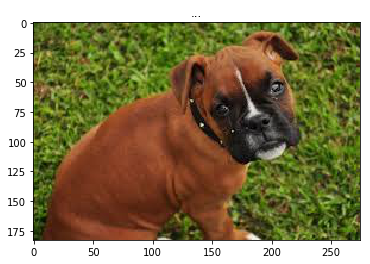

Try another!


Oh, we're sorry! We couldn't detect any dog or human face in the image.


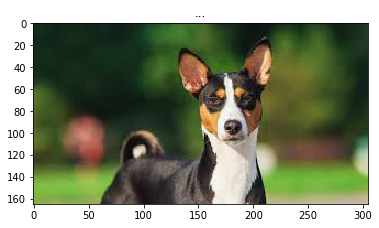

Try another!


Oh, we're sorry! We couldn't detect any dog or human face in the image.


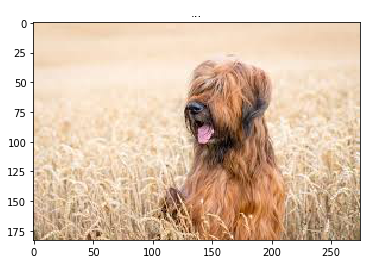

Try another!


Hello Human!


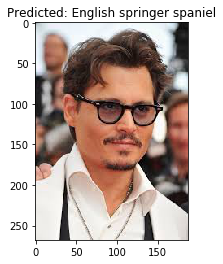

You look like a ...
English springer spaniel


Hello Human!


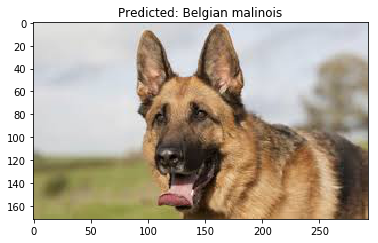

You look like a ...
Belgian malinois


Hello Human!


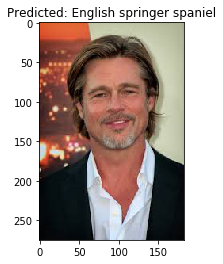

You look like a ...
English springer spaniel




In [56]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
#for file in np.hstack((human_files[:3], dog_files[:3])):
for file in custom_files:
    run_app(file)
#model_dog_detector = ALEXNET

In [58]:
# rewrite the run_app with dog detector(ALEXNET)
def run_app(img_path):
    
    
    ## handle cases for a human face, dog, and neither
    if (face_detector(img_path)):
            print("Hello Human!")
            predicted_breed = predict_breed_transfer(img_path)
            display_image(img_path, title="Predicted: {}".format(predicted_breed) )

            print("You look like a ...")
            print(predicted_breed)

        # check if image has dogs:
    elif dog_detector(img_path,model_dog_detector,device):
            print("Hello Dog!")
            predicted_breed = predict_breed_transfer(img_path)
            display_image(img_path, title="Predicted: {}".format(predicted_breed) )

            print("Your breed is most likley ...")
            print(predicted_breed)
        # otherwise
    else:
            print("Oh, we're sorry! We couldn't detect any dog or human face in the image.")
            display_image(img_path, title="...")
            print("Try another!")

    print("\n")
    


Hello Dog!


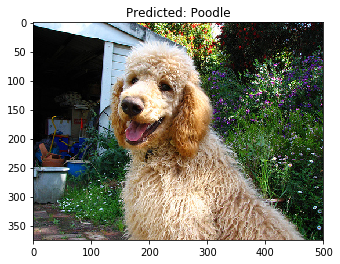

Your breed is most likley ...
Poodle


Hello Dog!


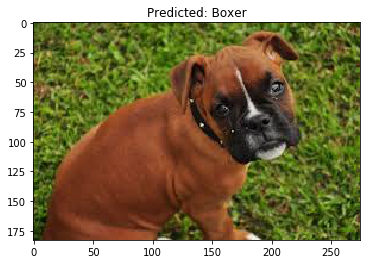

Your breed is most likley ...
Boxer


Hello Dog!


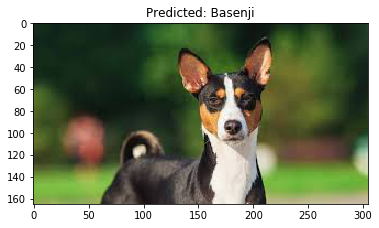

Your breed is most likley ...
Basenji


Hello Dog!


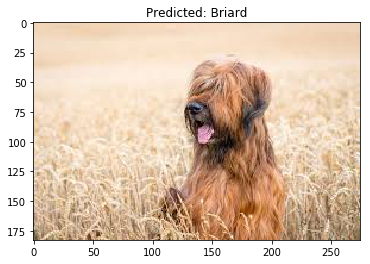

Your breed is most likley ...
Briard


Hello Human!


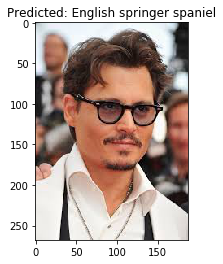

You look like a ...
English springer spaniel


Hello Human!


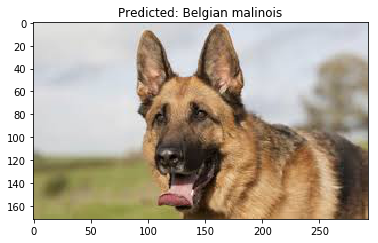

You look like a ...
Belgian malinois


Hello Human!


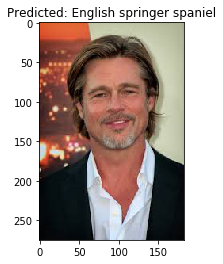

You look like a ...
English springer spaniel




In [59]:
for file in custom_files:
    run_app(file)